In [18]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Final summary
# 1. Introduction to BatchNormalization as modern standard technique to stabilize training of deep networks
# 2. PyTorchify code into modules (same layers exist in torch.nn)
# 3. Introduction to diagnostics tools to monitor whether neural netowrk is training properly (forward activation, backwards gradients, weights and grad:data, updates:data ratios roughly 1e-3)

In [19]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [20]:
len(words)

32033

In [21]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [22]:
# build the dataset
blocksize = 3 # context length: how many characters do we take to predict the next one
splits = [0.8, 0.1, 0.1]

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * blocksize  # index of '.' characters
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
split1, split2 = int(splits[0]*len(words)), int((splits[0]+splits[1])*len(words))
X_train, Y_train = build_dataset(words[:split1])
X_val, Y_val = build_dataset(words[split1:split2])
X_test, Y_test = build_dataset(words[split2:])

X_train.shape, X_val.shape, X_test.shape
Y_train.shape, Y_val.shape, Y_test.shape

(torch.Size([182625]), torch.Size([22655]), torch.Size([22866]))

In [23]:
# Define MLP
g = torch.Generator().manual_seed(2147483647)

def init_nn(hidden_dim=100, emb_dim=2):
    global C, W1, b1, W2, b2, parameters
    C = torch.randn((27, emb_dim), generator=g)
    W1 = torch.randn((blocksize * emb_dim, hidden_dim), generator=g)
    b1 = torch.randn(hidden_dim, generator=g)
    W2 = torch.randn((hidden_dim, 27), generator=g) * 0.1
    b2 = torch.randn(27, generator=g) * 0
    
    parameters = [C, W1, b1, W2, b2]
    for p in parameters:
        p.requires_grad = True

    
# Long form
emb_dim = 10
hidden_dim = 200

# Lets create embedding (lookup table) for 27 characters into 2 dimensions
C = torch.randn((27, emb_dim), generator=g)

# Let us create hidden layer
# input layer has blocksize * 2 neurons (2 is embedding dimension)
W1 = torch.randn((blocksize * emb_dim, hidden_dim), generator=g) # * 0.2  # factor for problem 2 of dead neurons
# Corretly Kaiming initialization for ReLU
# W1 = torch.randn((blocksize * emb_dim, hidden_dim), generator=g) * (5/3) / ((blocksize * emb_dim) ** 0.5) # i.e. gain / sqrt(fan_in)
b1 = torch.randn(hidden_dim, generator=g) # * 0.01  # factor for problem 2 of dead neurons

# Create output layer 
W2 = torch.randn((hidden_dim, 27), generator=g) * 0.1  # factor for problem 1 of initialization loss is off
b2 = torch.randn(27, generator=g) * 0  # factor for problem 1 of initialization loss is off

parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [36]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
  Xb, Yb = X_train[ix], Y_train[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 4.2326
  10000/ 200000: 2.1403
  20000/ 200000: 2.4720
  30000/ 200000: 2.5577
  40000/ 200000: 2.0154
  50000/ 200000: 2.4307
  60000/ 200000: 2.3385
  70000/ 200000: 2.0680
  80000/ 200000: 2.2665
  90000/ 200000: 2.1172
 100000/ 200000: 1.9299
 110000/ 200000: 2.0630
 120000/ 200000: 1.8901
 130000/ 200000: 2.3980
 140000/ 200000: 2.2826
 150000/ 200000: 2.1250
 160000/ 200000: 1.8469
 170000/ 200000: 1.7627
 180000/ 200000: 1.9119
 190000/ 200000: 1.8235


In [ ]:
# Let fix some problems with the MLP

# loss log history

# Original
# train loss: 2.20
# val loss: 2.25

# Fix 1: fix softmax confidendly wrong at init:
# train loss: 2.10
# val loss: 2.15

# Fix 2: fix tanh layer too saturated at init:
# train loss: 2.03
# val loss: 2.10

# Fix 3: used semi-principled "kaiming" initialization instead of hand-tuned initialization
# train loss: 2.03
# val loss: 2.16

# Fix 4: used BatchNorm to fix activation scale throughout training
# train loss: 2.07
# val loss: 2.10

# Original only working at all because small network, which is more forgiving for these effects.
# In large networks these problems get amplified and training fails.

# Happening because more time in effective training (no additional training steps just for good initialization)

In [32]:
# 1. Initialization is off, would expect uniform distribution and on average the following loss for each character
# Shows we get initally ~20 vs. expect ~3.3
print(-torch.tensor(1/27).log())

# 4-dimensional examples of the issue
# logits = torch.tensor([-1.0, 20.0, 1.0, 1.0]) # problem, when logits have large differnce, can initlly guess very wrong
logits = torch.tensor([1.0, 1.0, 1.0, 1.0]) # all the same, fine (usually for symmetrie should all be 0)
#logits = torch.randn(4) * 10
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
logits, probs, loss

# E.g. first row of logits from inital MLP after first step of training with loss 27.88
# tensor([  9.8054, -10.7094, -18.9225,   4.5784,  25.0958,  12.3420,  25.2245,
#           2.3172,  23.1374, -15.8994,  -1.2803, -13.0714,  11.7869,  21.8830,
#         -10.2817, -10.7709,  13.7777,  -7.2771,  -1.5731,  15.3102,  -0.5203,
#         -18.8392,  30.8516,  16.5554, -18.1451,   2.9022, -36.2960],
#         grad_fn=<SelectBackward0>)

# Inital fix: b2 = 0, W2 scaled with 0.1
# b2=0, W2 * 0.1: inital loss from 27.8 to 4.2
# Why not set W2 to 0 -> can often cause problems (see later)
# b2=0, W2 * 0.01: inital loss to 3.3

# Two heuristics considering the loss
# - loss at initalization what you would expect, e.g. here uniform
# - loss should not be a hockey stick


tensor(3.2958)


(tensor([1., 1., 1., 1.]),
 tensor([0.2500, 0.2500, 0.2500, 0.2500]),
 tensor(1.3863))

In [21]:
h.shape

torch.Size([32, 200])

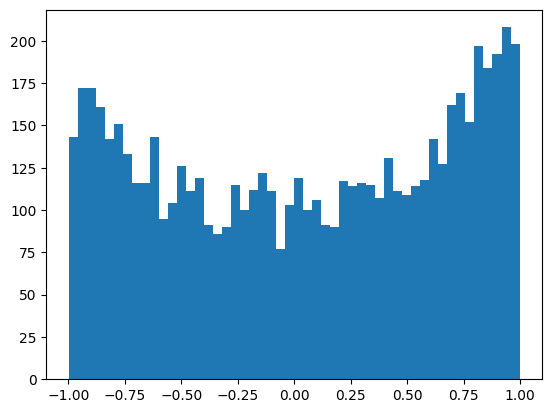

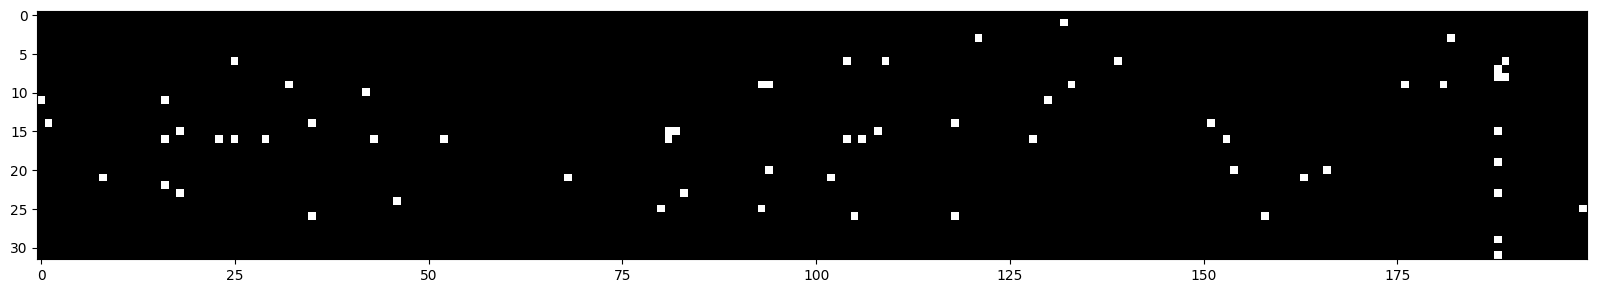

In [30]:
# 2. Most of hidden values are close to -1 and 1 -> should make us sweating aka "permanent brain damage of neurons"
# Again let model do only single update step
plt.hist(h.view(-1).tolist(), 50)

# Preactivations are very broad between -15 and 15 -> leading to squashing to -1 and 1 by the tanh
# plt.hist(hpreact.view(-1).tolist(), 50)

# Intuituvely for tanh, for -1 and 1 the gradient is very small -> so learning is slow
# Also consider backprop through tanh: (1 - t**2) * out.grad -> if t is close to -1 or 1, the gradient (1 - t**2) is close to 0
# => or to visualize the neuron is stuck in the flat region of tanh, even for relatively large changes in preactivation, we stick there
# => also, looking at (1 - t**2) * out.grad -> the gradient update through a tanh can only decreased (multiplied by sth. between 0 and 1)

# Lets check for occurrences in the hidden layer where large preactivation but small gradient
# => column of white = dead neuron
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest') # white is true --> lot of tanh are very active and in flat tail -> backward signal destroyed

# This problem also occurs for other activation functions, e.g. ReLU (https://medium.com/@shrutijadon/survey-on-activation-functions-for-deep-learning-9689331ba092)
# E.g. if ReLU neuron has negative preactivation, i.e. through all examples given the input weights and bias it is negative, then the neuron is dead
# => never activates, never gets gradient updates, stays dead forever
# => can happen during initialization, but also during training with too large learning rates

# Fixes:
# - change preactivations (i.e. incoming weights and/or bias) to be smaller -> less likely to be in flat region
# - b1 = b1*0.01 (Karpathy likes it to have some variation to help optimization)
# - W1 = W1*0.2

In [ ]:
logits[0]

tensor([  9.8054, -10.7094, -18.9225,   4.5784,  25.0958,  12.3420,  25.2245,
          2.3172,  23.1374, -15.8994,  -1.2803, -13.0714,  11.7869,  21.8830,
        -10.2817, -10.7709,  13.7777,  -7.2771,  -1.5731,  15.3102,  -0.5203,
        -18.8392,  30.8516,  16.5554, -18.1451,   2.9022, -36.2960],
       grad_fn=<SelectBackward0>)

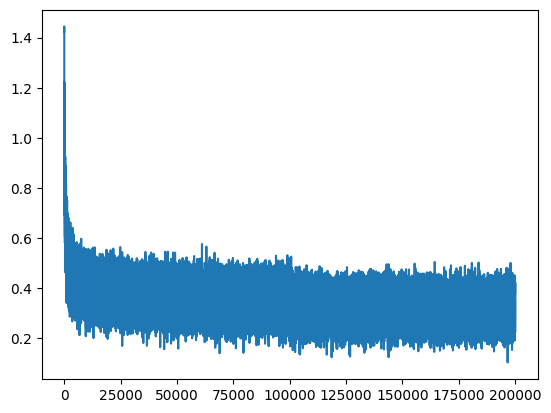

In [ ]:
plt.plot(lossi)

In [33]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (X_train, Y_train),
    'val': (X_val, Y_val),
    'test': (X_test, Y_test)
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.03735089302063
val 2.10432767868042


In [ ]:
# Section: Fixing the init scale
# Trying to generalize the problem of setting scaling hyperparameters
# Example below takes 1000 examples of dimension 10 and determines preactivations from hidden layer of dimension 200

x = torch.randn(1000, 10)
# w = torch.randn(10, 200) # -> no normalization variance of preactivations 3.18 
w = torch.randn(10, 200) * (1/10)**0.5  # -> normalized variance of preactivations 1.0
y = x @ w

# Determin and visualize distribution of preactivations y
print (x.mean(), x.std())
print (y.mean(), y.std())
plt. figure(figsize=(20, 5))
plt. subplot (121)
plt. hist(x.view(-1).tolist(), 50, density=True);
plt. subplot (122)
plt.hist(y.view(-1). tolist(), 50, density=True);

# General idea: All activations should roughly have a Gaussian distribution with zero mean and unit variance

# Paper studying normalization: Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification (https://arxiv.org/abs/1502.01852)
# 1. Study ReLU that clamps negative values to zero (so diregards negative part), hence find they need to scale with sqrt(2/fan_in) instead of sqrt(1/fan_in) as here
# 2. If forward pass is normalized, then backward pass is also almost stable up to a constant factor

# Implemented in PyTorch as "Kaiming Initialization" in https://docs.pytorch.org/docs/stable/nn.init.html
# - Gain of sqrt(2) for ReLU
# - Gain of 5/3 for tanh (as used here) -> since squeezing function reduces variance, need to increase it

# Correctly implementing intialization and normalization was extremely important, some modern developments helped with that:
# - Residual connections
# - Normalization layers (BatchNorm, LayerNorm, GroupNorm etc.)
# - Advanced optimizers (Adam, RMSProp etc.) instead of plain SGD

# Rule of thumb for initialization of weights: intialize with sqrt(fan_in)

In [ ]:
# Section: Batch Normalization
# - Introduced in 2015 in the paper Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift (https://arxiv.org/abs/1502.03167)
# - Overview in Algorithm 1 of the paper
#   - Idea: normalize activations of each layer to have zero mean and unit variance at initialization
#   - During training, add two learnable parameters per neuron to allow the network to scale and shift the normalized activations (possible to recover original representation if needed)
# - Key realization: everything is differentiable, so backpropagation works through the normalization step
# - Works extremely well in practice, often allows to use much larger learning rates and speeds up

# Weird side effect: examples in batch are no longer independent, since normalization depends on the entire batch, i.e. prediction of one example depends on other examples in the batch
# - This actually acts as a regularizer, often less need for other regularization techniques like dropout
# - To remove this batch dependency, people have tried to introduce alternatives such as LayerNorm, GroupNorm, InstanceNorm etc.
# - To sum up, BatchNorm one of the first normalization layers, still widely used and very effective even though people do not like the batch dependency

# Two subleties when using BatchNorm:
# 1. Small eps should be added to variance when normalizing to avoid division by zero
# 2. Adding bias before BatchNorm is redundant, since BatchNorm removes this bias anyway by centering the activations (so can save some parameters)

# Comparing final implementation motives with ResNet from https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py (see Bottleneck class)
# - Also stacked processing of conv (linear layer for spatial patches), BatchNorm, non-linearity (ReLU here) with final residual connection
# - Also no bias in conv layers before BatchNorm
# - Our implementation of linear layer and BatchNorm also follows PyTorch: https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html

# Define MLP with BatchNorm
g = torch.Generator().manual_seed(2147483647)

emb_dim = 10
hidden_dim = 200

C = torch.randn((27, emb_dim), generator=g)
W1 = torch.randn((blocksize * emb_dim, hidden_dim), generator=g) * (5/3) / ((blocksize * emb_dim) ** 0.5) # Kaiming initialization for tanh
# b1 = torch.randn(hidden_dim, generator=g) * 0.01 # bias redundant with BatchNorm
W2 = torch.randn((hidden_dim, 27), generator=g) * 0.01
b2 = torch.randn(27, generator=g) * 0  

# BatchNorm parameters
bn_gain = torch.ones((1, hidden_dim))
bn_bias = torch.zeros((1, hidden_dim))
# Running estimates for mean and stddev - buffers with no gradients
bn_mean_running = torch.zeros((1, hidden_dim))
bn_std_running = torch.ones((1, hidden_dim))

parameters = [C, W1, W2, b2, bn_gain, bn_bias]
for p in parameters:
    p.requires_grad = True

In [ ]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
  Xb, Yb = X_train[ix], Y_train[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  # hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  hpreact = embcat @ W1  # bias redundant with BatchNorm

  # Implement BatchNorm layer - importanly, everything is differentiable
  # ----------------------------------------------------------------------------
  # hpreact_mean = hpreact.mean(0, keepdim=True)
  # hpreact_std = hpreact.std(0, keepdim=True)
  # hpreact = (hpreact - hpreact_mean) / hpreact_std
  # hpreact = bn_gain * hpreact + bn_bias
  # Or for short
  bnmean_i = hpreact.mean(0, keepdim=True)
  bnstd_i = hpreact.std(0, keepdim=True)
  # Two operations
  # 1. Normalize to zero mean and unit variance
  # 2. Scale and shift with learnable parameters (from untit Gaussian to original distribution if needed)
  hpreact = bn_gain * (hpreact - bnmean_i) / bnstd_i + bn_bias

  with torch.no_grad():
    momentum = 0.001  # smooth running estimates
    bn_mean_running = (1 - momentum) * bn_mean_running + momentum * bnmean_i
    bn_std_running = (1 - momentum) * bn_std_running + momentum * bnstd_i
  # ----------------------------------------------------------------------------
  
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.3239
  10000/ 200000: 2.0322
  20000/ 200000: 2.5675
  30000/ 200000: 2.0125
  40000/ 200000: 2.2446
  50000/ 200000: 1.8897
  60000/ 200000: 2.0785
  70000/ 200000: 2.3681
  80000/ 200000: 2.2918
  90000/ 200000: 2.0238
 100000/ 200000: 2.3673
 110000/ 200000: 2.3132
 120000/ 200000: 1.6414
 130000/ 200000: 1.9311
 140000/ 200000: 2.2231
 150000/ 200000: 2.0027
 160000/ 200000: 2.0997
 170000/ 200000: 2.4949
 180000/ 200000: 2.0199
 190000/ 200000: 2.1707


In [36]:
# Problem with BatchNorm at test time: how to set the mean and stddev of BatchNorm for a single examples
# Workaround: After training, compute the mean and stddev over the entire training set and use those for normalization at test time

# calibrate the batch norm at the end of training
# finally replaced with running mean/stddev during training (more complicated)
with torch.no_grad():
    emb = C[X_train]
    embcat = emb.view(emb.shape[0], -1) 
    # hpreact = embcat @ W1 + b1
    hpreact = embcat @ W1
    # compute mean and stddev over entire training set
    bn_mean = hpreact.mean(0, keepdim=True)
    bn_std = hpreact.std(0, keepdim=True)


# Check that running mean/stddev are close to calibrated ones
print(f"Running mean diff: {(bn_mean_running - bn_mean).abs().max().item():.6f}, stddev diff: {(bn_std_running - bn_std).abs().max().item():.6f}")

Running mean diff: 0.026631, stddev diff: 0.053666


In [37]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (X_train, Y_train),
    'val': (X_val, Y_val),
    'test': (X_test, Y_test)
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  # hpreact = embcat @ W1 + b1
  hpreact = embcat @ W1
  # BatchNorm - use calibrated mean and stddev to be able to forward single examples
  hpreact = bn_gain * (hpreact - bn_mean_running) / bn_std + bn_bias
  
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.067678928375244
val 2.105555295944214


In [ ]:
# Summary of the lecture
# - Importance of understanding the activations and gradients and their statistics throughout the network
# - Increasingly important as networks get deeper and more complex
# - One indicator if this is off: hockey-stick loss during training (fixing it makes loss decrease more smoothly)
# - Want to control for effect of activations: neither squash to zero or expand to infinity
# - You want everything in the net fairly homogeneous distribution (e.g. Gaussian with zero mean and unit variance)
# - BatchNorm idea: if you want Gaussian with zero mean and unit variance, just enforce it at every layer with learnable deviations from it (two parameters)
# - No one likes this layer due to batch dependency and many potentials for bugs, but it works extremely well in practice
# - Alternatives: LayerNorm, GroupNorm, InstanceNorm etc.

In [ ]:


# Sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * 3
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
        
    print(''.join(itos[i] for i in out))

carmah.
ambrilli.
kimri.
rehtlinna.
sane.
mahnen.
deliah.
jaree.
corrisephanaiir.
kaleigh.
ham.
join.
quinton.
lilea.
jamilio.
jerry.
jarynix.
kael.
drudi.
emmedo.


tensor(0.0252) tensor(1.0026)
tensor(-0.0011) tensor(1.0105)


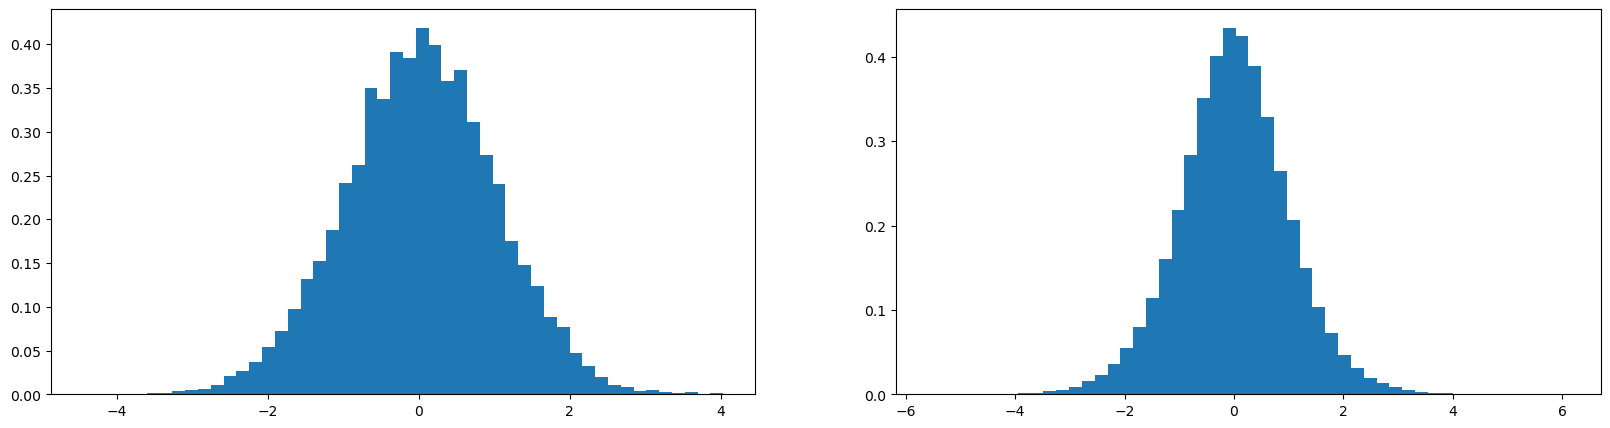

In [80]:
# Further summary and restructuring code in PyTorch format

from re import L


class Linear:
    # See: https://docs.pytorch.org/docs/stable/generated/torch.nn.Linear.html
    
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5  # Kaiming initialization
        self.bias = torch.zeros(fan_out) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
    
class BatchNorm1d:
    # See: https://docs.pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html
    
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True  # many models different behavior in train and eval mode
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self, x):
        # calculate the forward pass
        if self.training: # batch statistics
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True, unbiased=True)
        else: # during inference use running estimates
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]


class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return [] 
        
        
n_embd = 10 # the dimension of the character embeddings vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647)
vocab_size = 27

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd * blocksize, n_hidden), Tanh(),
    Linear(          n_hidden, n_hidden), Tanh(),
    Linear(          n_hidden, n_hidden), Tanh(),
    Linear(          n_hidden, n_hidden), Tanh(),
    Linear(          n_hidden, n_hidden), Tanh(),
    Linear(          n_hidden, vocab_size),
]

# Some initialization due to depth of network
with torch.no_grad():
    # last layer: make less confident at initialization
    layers[-1].weight *= 0.1
    # all other layers: apply gain as is Tanh Kaiming initialization
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3 # For visualization 1, change to 1 / 0.5 / 3
            
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))  # number of parameters
for p in parameters:
    p.requires_grad = True
        

46497


In [81]:
# Same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
# Added tracking of update to data ratio
ud = []

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
    Xb, Yb = X_train[ix], Y_train[ix] # batch X,Y
    
    # forward pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    logits = x
    loss = F.cross_entropy(logits, Yb) # loss function
    
    # backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    # change lr for final visualization of update to data ratio (0.1 -> 0.001)
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])
    
    if i >= 1000:
        break # AFTER_DEBUG: would remove

      0/ 200000: 3.2962


layer 1 (      Tanh): mean -0.04, std 0.76, saturated: 21.97%
layer 3 (      Tanh): mean -0.01, std 0.72, saturated: 11.00%
layer 5 (      Tanh): mean +0.01, std 0.73, saturated: 13.00%
layer 7 (      Tanh): mean -0.05, std 0.73, saturated: 13.34%
layer 9 (      Tanh): mean +0.00, std 0.72, saturated: 10.53%


Text(0.5, 1.0, 'activation distribution')

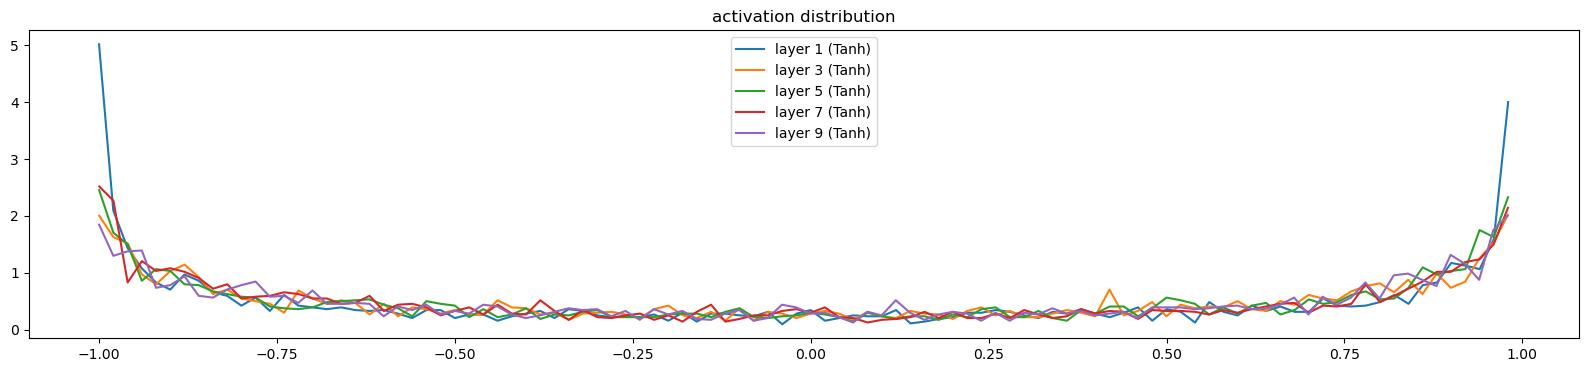

In [ ]:
# 1. visualize histograms for activations in each layer to observe whether they are well normally distributed or squased / expanded
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []

for i, layer in enumerate (layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out
        # Determin saturation as percentage of activations close to -1 or 1
        print('layer %d (%10s): mean %+0.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean().item(), t.std().item(), (t.abs() > 0.97).float().mean().item() * 100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach()) 
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend (legends);
plt.title( 'activation distribution')

# Takeaway from this visualization:
# - For correct gain of 5/3 in Kaiming normalization: first layer (blue) 20% saturated, but stabilization throughout the network
# - For no gain (i.e. gain=1): first layer (blue) still relaitively ok, but later layers get more and more squashed (std decreaseses) due to squashing non-linearity of tanh
# - For gain of 3: activations expand throughout the network, more and more saturated neurons (most activations close to -1 or 1)

layer 1 (      Tanh): mean +0.000024, std 3.353992e-03
layer 3 (      Tanh): mean +0.000012, std 3.157345e-03
layer 5 (      Tanh): mean -0.000004, std 2.925863e-03
layer 7 (      Tanh): mean +0.000036, std 2.715700e-03
layer 9 (      Tanh): mean +0.000020, std 2.308167e-03


Text(0.5, 1.0, 'gradient distribution')

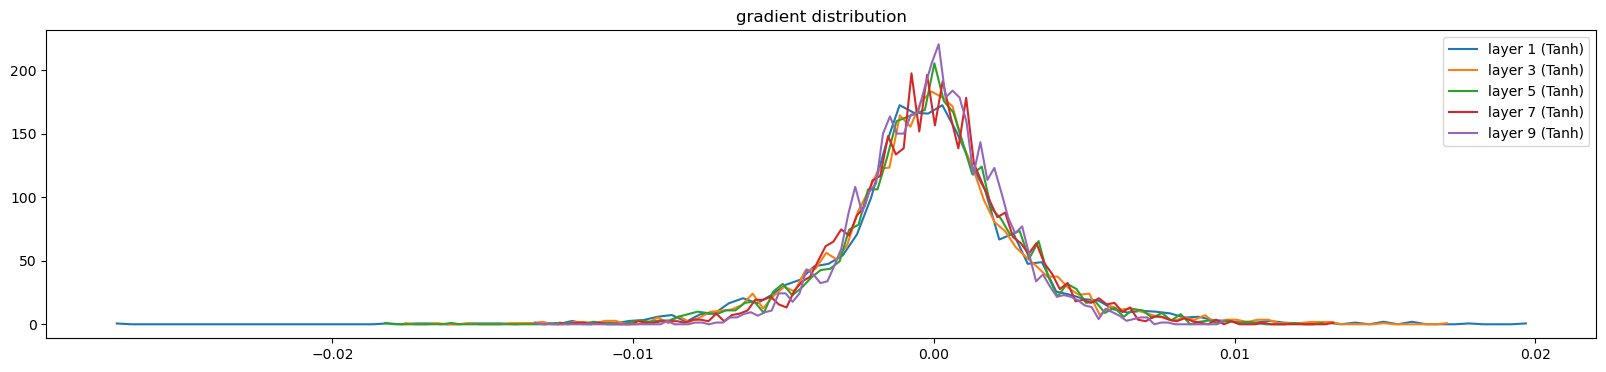

In [ ]:
# 2. visualize histograms of gradients
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean (), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('gradient distribution')

# Analysis of gradients:
# - For correct gain of 5/3 in Kaiming normalization: gradients fairly stable across layers
# - For gain of 0.5: activations squased -> gradients get larger and larger in later layers -> exploding gradients
# - For gain of 3: activations stretched -> gradients get smaller and smaller in later layers -> vanishing gradients

# In general for observation of activations (forward pass) and gradients (backward pass):
# - Want to have neither squashed nor stretched distributions
# - If gain too small: activations squashed, gradients explode
# - If gain too large: activations stretched, gradients vanish
# => Due to this it used to be very hard to train deep networks
# => Modern architectures (ResNets, Transformers etc.) along with normalization layers (BatchNorm, LayerNorm etc.) help a lot with this

weight|   (27, 10) | mean +0.000980 | std 1.189171e-02 | grad:data ratio 1.189150e-02
weight|  (30, 100) | mean +0.000118 | std 1.005291e-02 | grad:data ratio 3.214557e-02
weight| (100, 100) | mean +0.000033 | std 7.821214e-03 | grad:data ratio 4.653364e-02
weight| (100, 100) | mean -0.000107 | std 6.655622e-03 | grad:data ratio 3.925852e-02
weight| (100, 100) | mean -0.000017 | std 6.086041e-03 | grad:data ratio 3.605768e-02
weight| (100, 100) | mean -0.000077 | std 5.075621e-03 | grad:data ratio 3.015269e-02
weight|  (100, 27) | mean -0.000000 | std 2.056585e-02 | grad:data ratio 2.909911e-01


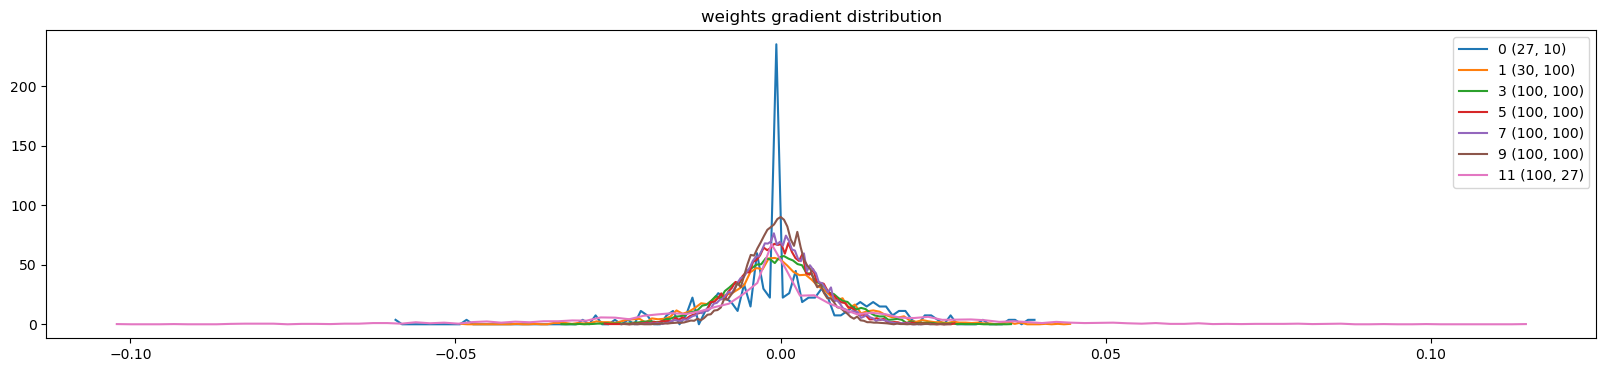

In [ ]:
# 3. visualize histograms of 2D weights
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print( 'weight| %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), (t.std()) / (p.data.std())))
        # Visualize grad:data ratio to get a sense of how large the updates are compared to the current weights
        # Not that important, but rather update to data ratio
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

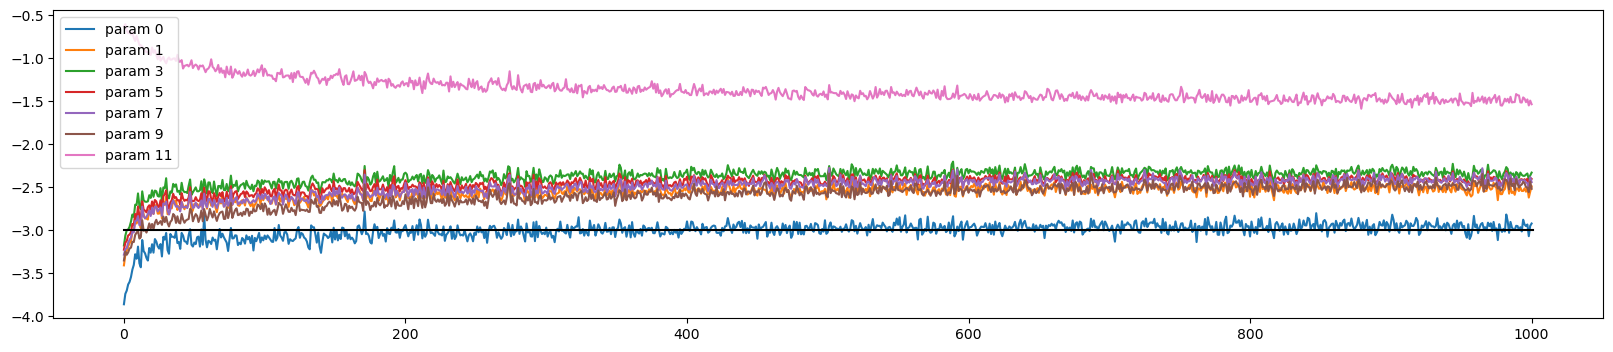

In [ ]:
# 4. visualize update rations over time

plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot <- what they roughly should be (one thousandth)
plt.legend(legends)

# Takeaways from update to data ratios:
# - Want to observe that updates are in expected range ~1e-3 of data
# - Observe larger rations for last layer, since initialized with smaller weights; can observe that stabilizes over time
# - If updates are below 1e-3: network usually not learning fast enough
# - So, for lr of 0.001: updates much too small (updates ten thousandth of data or less) -> increase lr

In [ ]:
# Now put BatchNorm layers into the network
# - All visualization now look very homogeneous throughout the network
# - Now much less brittle, e.g. chaging gain to 0.2, activations and gradients okay due to normalization, but updates will change (visualization 4)
# - So no everything perfect, but much more robust than before

n_embd = 10 # the dimension of the character embeddings vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647)
vocab_size = 27

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd * blocksize, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(          n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(          n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(          n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(          n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(          n_hidden, vocab_size), BatchNorm1d(vocab_size),
]

# Some initialization due to depth of network
with torch.no_grad():
    # last layer: make less confident at initialization
    layers[-1].gamma *= 0.1
    # all other layers: apply gain as is Tanh Kaiming initialization
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3 # For visualization 1, change to 1 / 0.5 / 3
            
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))  # number of parameters
for p in parameters:
    p.requires_grad = True

47551


In [87]:
# Same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
# Added tracking of update to data ratio
ud = []

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
    Xb, Yb = X_train[ix], Y_train[ix] # batch X,Y
    
    # forward pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    logits = x
    loss = F.cross_entropy(logits, Yb) # loss function
    
    # backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    # change lr for final visualization of update to data ratio (0.1 -> 0.001)
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])
    
    if i >= 1000:
        break # AFTER_DEBUG: would remove

      0/ 200000: 3.2870


layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.62%
layer 5 (      Tanh): mean +0.00, std 0.64, saturated: 2.47%
layer 8 (      Tanh): mean -0.00, std 0.64, saturated: 2.16%
layer 11 (      Tanh): mean +0.00, std 0.65, saturated: 1.81%
layer 14 (      Tanh): mean -0.00, std 0.65, saturated: 1.78%


Text(0.5, 1.0, 'activation distribution')

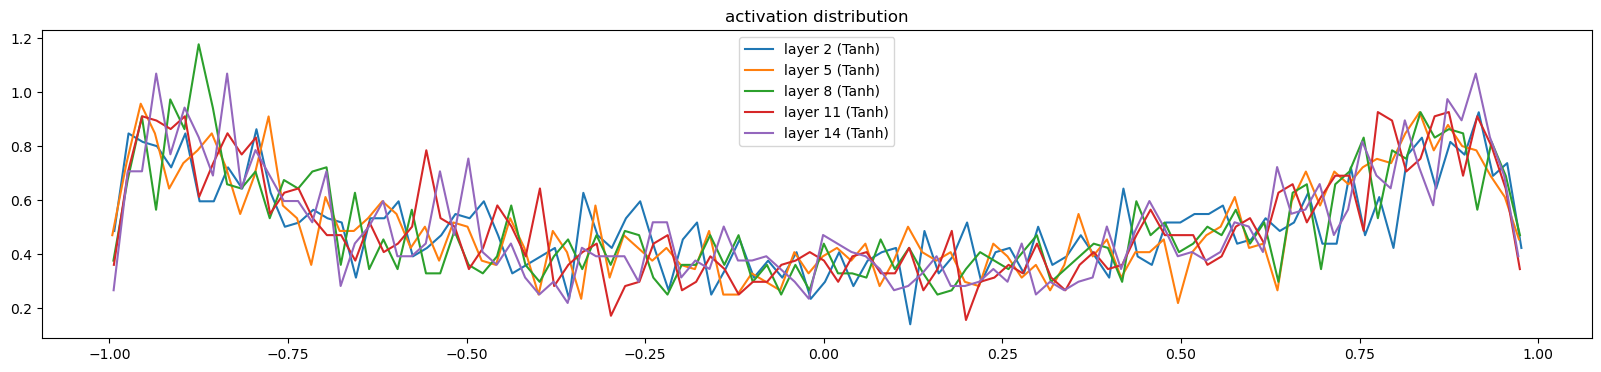

In [ ]:
# 1. visualize histograms for activations in each layer to observe whether they are well normally distributed or squased / expanded
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []

for i, layer in enumerate (layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out
        # Determin saturation as percentage of activations close to -1 or 1
        print('layer %d (%10s): mean %+0.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean().item(), t.std().item(), (t.abs() > 0.97).float().mean().item() * 100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach()) 
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend (legends);
plt.title( 'activation distribution')

layer 2 (      Tanh): mean +0.000000, std 3.682950e-03
layer 5 (      Tanh): mean -0.000000, std 3.262606e-03
layer 8 (      Tanh): mean -0.000000, std 2.973729e-03
layer 11 (      Tanh): mean +0.000000, std 2.741107e-03
layer 14 (      Tanh): mean -0.000000, std 2.584293e-03


Text(0.5, 1.0, 'gradient distribution')

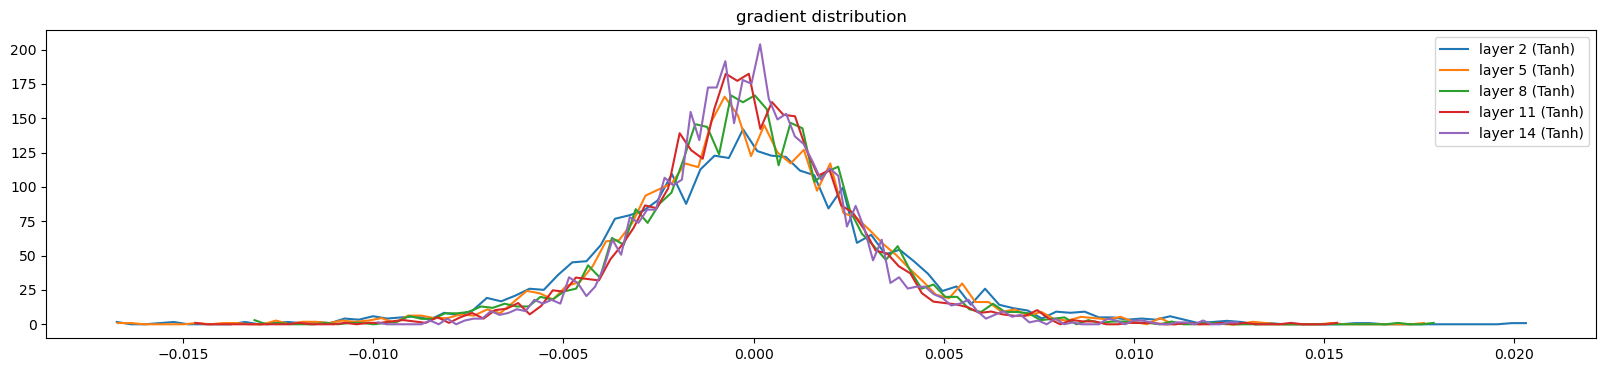

In [89]:
# 2. visualize histograms of gradients
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean (), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('gradient distribution')

weight|   (27, 10) | mean +0.000000 | std 1.019883e-02 | grad:data ratio 1.018844e-02
weight|  (30, 100) | mean +0.000092 | std 8.238419e-03 | grad:data ratio 2.635835e-02
weight| (100, 100) | mean +0.000031 | std 7.318100e-03 | grad:data ratio 4.377137e-02
weight| (100, 100) | mean -0.000019 | std 6.662020e-03 | grad:data ratio 3.949894e-02
weight| (100, 100) | mean -0.000019 | std 5.821514e-03 | grad:data ratio 3.468160e-02
weight| (100, 100) | mean +0.000053 | std 5.445292e-03 | grad:data ratio 3.243364e-02
weight|  (100, 27) | mean -0.000165 | std 1.046843e-02 | grad:data ratio 6.281257e-02


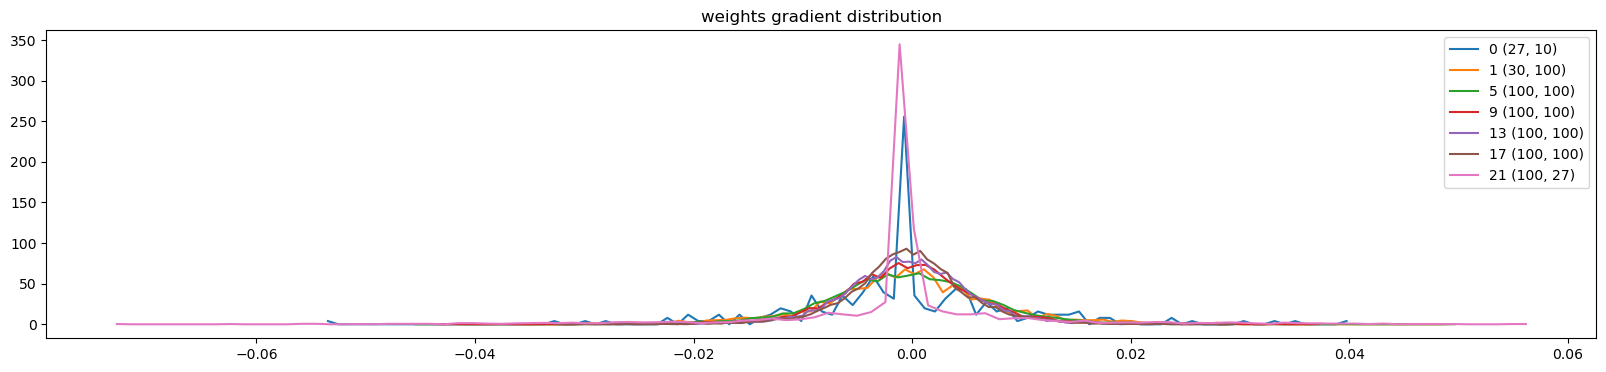

In [90]:
# 3. visualize histograms of 2D weights
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print( 'weight| %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), (t.std()) / (p.data.std())))
        # Visualize grad:data ratio to get a sense of how large the updates are compared to the current weights
        # Not that important, but rather update to data ratio
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

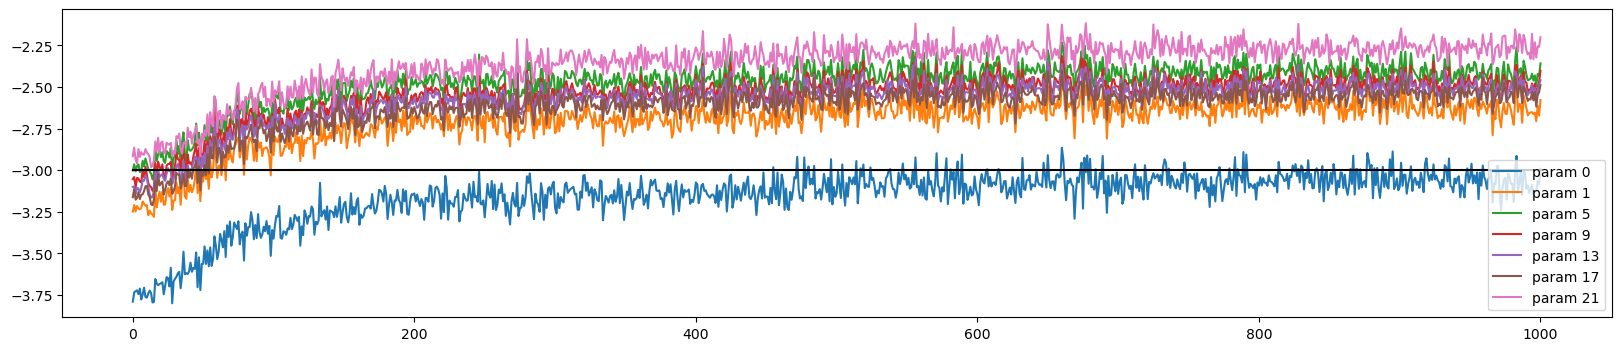

In [ ]:
# 4. visualize update rations over time

plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot <- what they roughly should be (one thousandth)
plt.legend(legends)
